In [ ]:
### Deze code is gebruikt om de experimenten van RobBERT mee te runnen.
### Voor verdere documentatie, zie BERT_train_cased_sentence_analysis.ipynb.
### This code was used to experiment using RobBERT.
### For further documentation, see BERT_train_cased_sentence_analysis.ipynb.

In [1]:
# code aangepast van / code adjusted from https://www.philschmid.de/bert-text-classification-in-a-different-language
!ipython kernel install --user --name DataLabDisc
!which jupyter
!pip list

Installed kernelspec DataLabDisc in /data/milenadeswart/.local/share/jupyter/kernels/datalabdisc
/data/anaconda3/bin/jupyter
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Package                            Version
---------------------------------- -----------
absl-py                            2.1.0
accelerate                         0.20.3
aiohttp                            3.8.6
aiosignal                          1.3.1
alabaster                          0.7.12
alembic                            1.6.5
altair                             5.0.1
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
annotated-types                    0.5.0
anyio                              3.7.1
appdirs                            1.4.4
asn1crypto                         1.0.1
astroid                 

SQLAlchemy                         1.3.9
statsmodels                        0.10.1
streamlit                          1.23.1
sympy                              1.4
tables                             3.5.2
tblib                              1.4.0
tenacity                           8.2.3
tensorboard                        2.11.2
tensorboard-data-server            0.6.1
tensorboard-plugin-wit             1.8.1
tensorflow                         2.11.0
tensorflow-estimator               2.11.0
tensorflow-io-gcs-filesystem       0.34.0
termcolor                          2.3.0
terminado                          0.8.2
testpath                           0.4.2
threadpoolctl                      3.1.0
tinycss2                           1.2.1
tokenizers                         0.13.3
toml                               0.10.2
tomli                              2.0.1
toolz                              0.10.0
torch                              1.13.1
tornado                            6.2
tqdl      

In [2]:
# importeer benodigde packages
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics as metrics
from scipy.special import expit
import seaborn as sns
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyarrow
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import ClassificationArgs
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

seed = 9

In [3]:
# check device waarop de code runt
# check device that runs code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [4]:
# gebruik pretrained model (cased!): https://huggingface.co/GroNLP/bert-base-dutch-cased
# load model necessary
#tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
#model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

#tokenizer = AutoTokenizer.from_pretrained("DTAI-KULeuven/robbert-2023-dutch-base")
#model = AutoModelForSequenceClassification.from_pretrained("DTAI-KULeuven/robbert-2023-dutch-base")

tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert_dutch_base_offensive_language")
model = AutoModelForSequenceClassification.from_pretrained("GroNLP/bert_dutch_base_offensive_language")

In [5]:
# inladen & mergen data
# load & merge data
def merge_annotated_data(naam_dataset, n_annotators, n_annotations = 3):
    """ functie die de gesplitste data gesplitst door split_annotated_data weer kan samenvoegen.
    De datasets met de naam naam_dataset_n_annotators.csv worden ingeladen. Vervolgens wordt de oorspronkelijke dataset gereconstrueerd
    uit de ingeladen data. De oorspronkelijke zinnen en het overzicht van de labels wordt gereturned.

    Input:
    naam_dataset: str, de naam van de documenen die de annotators hebben ingevuld
    n_annotators: int, het aantal annotators
    n_annotations: int, het aantal annotations per zin. default 3

    Output:
    merged_data: een DataFrame met daarin de oorspronkelijke data en de n_annotations labels die zijn toegekend.
    """

    """ function that can merge data split by split_annotated_data.
    The datasets with the name naam_dataset_n_annotators.csv are loaded. The original dataset then gets reconstructed
    from the loaded data. The original sentences and the overview of the original labels is returned.

    Input:
    name_dataset: str, the name of the documents that the annotators have filled in
    n_annotators: int, the number of annotators
    n_annotations: int, the number of annotations per sentence. Defaults to 3
    """
    
    # inladen path naar data en creëren lege frames
    # load data path and create empty frames
    dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/Datasets_2/" # server 1
   # dataset_path = "~/Projecten/programma-discriminatie-en-racisme/datasets/Datasets_2/" # server 2
    merged_data = pd.DataFrame()

    for i in range(n_annotators):
        # inladen annotated documenten en samenvoegen
        # load and compile annotated documents
        annotated_doc = pd.read_excel(dataset_path + naam_dataset + "_" + str(i) + '.xlsx')
        annotated_doc = annotated_doc.dropna(subset=['Label', 'text', 'Column1'])
        # print(len(annotated_doc))
        columns = list(annotated_doc.columns)

        # document opstellen
        # set up dataframe
        if i == 0:
            merged_data = annotated_doc
        else:
            merged_data = pd.concat([merged_data, annotated_doc])
    
    # data toevoegen uit extra bronnen
    # add extra data
    extra_zoekwoorden = pd.read_excel(dataset_path + 'te_verwijderen.xlsx') # van tweede search / from second search
    merged_data = pd.concat([merged_data, extra_zoekwoorden])
    
    missende_zoekwoorden = pd.read_excel(dataset_path + 'missing_words.xlsx') # van derde search / from third search
    merged_data = pd.concat([merged_data, missende_zoekwoorden])
    
    extra_migratie = pd.read_excel(dataset_path + 'extra_migratie.xlsx') # extra data
    merged_data = pd.concat([merged_data, extra_migratie])
    
    herlabelled = pd.read_excel(dataset_path + 'herlabellen.xlsx') # hergelabelde data / re-annotated data
    merged_data = pd.concat([merged_data, herlabelled])
    
    #display(merged_data)
    
    # groepeer data
    # group data
    aggregated_data = merged_data.groupby(['Column1']).agg({'id': 'last', 'titel': 'last', 'text': 'last', 'zin': 'last', 'word': 'last', 'Label': 'last'})

    return pd.DataFrame(merged_data), pd.DataFrame(aggregated_data)

merged, aggregated = merge_annotated_data('te_labellen', n_annotators = 8, n_annotations = 3)

display(merged)

169
451
423
421
604
772
296
545
5121 4679


,Column1,Column2,Label,aanhangselnummer,alias,api_gewijzigd_op,categorie,citeertitel,content_length,content_type,...,toelichting,type_document,url_document,vergaderjaar,vermijden,verwijderd,volgnummer,voorkeur,word,zin
3,26136,NaN,0.0,NaN,NaN,2024-02-20 06:48:04.095000,migratie,NaN,129657,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2018-2019,tsunami,0.0,3,NaN,stromen,51
5,18406,NaN,0.0,NaN,NaN,2024-02-23 18:15:17.654000,algemeen,NaN,43492,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2013-2014,NaN,0.0,4,NaN,macht,2
6,9109,NaN,7.0,NaN,NaN,2024-02-23 07:58:23.236000,talen buiten nl,NaN,1.78453e+06,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2009-2010,NaN,0.0,2,NaN,armoede,2
7,1887,NaN,0.0,NaN,NaN,2024-02-21 18:01:54.251000,seksualiteit,Wet seksuele misdrijven,287052,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2022-2023,NaN,0.0,7,NaN,seksueel,13
9,139,NaN,0.0,NaN,NaN,2024-02-21 16:59:39.016000,migratie,Wet vereenvoudiging en modernisering bewijsrecht,195871,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2021-2022,NaN,0.0,6,NaN,stroom,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,33861,421.0,1.0,NaN,NaN,2024-02-21 05:30:57.870000,gender,NaN,3611171,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2022-2023,NaN,0.0,7,NaN,kloof,6
57,4478,520.0,1.0,NaN,NaN,2024-02-21 15:39:47.985000,migratie,NaN,133315,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2016-2017,NaN,0.0,6,NaN,nieuwkomer,2
58,17405,523.0,1.0,NaN,NaN,2024-02-21 12:55:23.639000,algemeen,NaN,34737,application/pdf,...,"vermijd othering, rol slachtoffers",Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2015-2016,NaN,0.0,3,NaN,minderheden,10
59,10024,527.0,1.0,NaN,NaN,2024-02-22 10:30:14.182000,migratie,NaN,5243158,application/pdf,...,NaN,Hoofddocument,https://gegevensmagazijn.tweedekamer.nl/OData/...,2015-2016,NaN,0.0,2,NaN,migranten,1


In [6]:
# bekijken dataset
# view dataset
print(merged.columns)

pos = len(aggregated[aggregated.Label == 1.0])
neg = len(aggregated[aggregated.Label==0.0])
unclear = len(aggregated[aggregated.Label==4.0])
useless = len(aggregated[aggregated.Label==7.0])

print(f"The dataset has {pos} biased and {neg} unbiased instances for a total of {pos+neg}. There are {unclear} unclear labels and {useless} useless instances.")

Index(['Column1', 'Column2', 'Label', 'aanhangselnummer', 'alias',
       'api_gewijzigd_op', 'categorie', 'citeertitel', 'content_length',
       'content_type', 'datum', 'datum_ontvangst', 'datum_registratie',
       'document_nummer', 'doel', 'gewijzigd_op', 'id', 'id_hoofddocument',
       'kamer', 'kenmerk_afzender', 'labeller_1', 'labeller_2', 'labeller_3',
       'onderwerp', 'organisatie', 'pagina', 'soort', 'text', 'titel',
       'toelichting', 'type_document', 'url_document', 'vergaderjaar',
       'vermijden', 'verwijderd', 'volgnummer', 'voorkeur', 'word', 'zin'],
      dtype='object')
The dataset has 894 biased and 2738 unbiased instances for a total of 3632. There are 32 unclear labels and 1010 useless instances.


In [7]:
# vinden zoekwoorden die wel en niet aanwezig zijn in de dataset
# view search words present and absent in the dataset
zoekwoorden_set = set(merged['word'])

print(len(zoekwoorden_set))

zoekwoorden = ['meerbloed', 'hij of zij', 'rolstoelgebonden', 'Andere achtergrond', 'westers', 'mbo-leerling', 'slaven', 'berber', 'joods', 'zwarte school', 'grensoverschrijdend gedrag', 'halfbloed', 'gekleurd', 'hij/zij', 'ontwikkelingslanden', 'plusklassen', 'doventolk', 'probleembuurt', 'zittenblijven', 'zwart', 'lager opgeleid', 'minderheden', 'handicap', 'blank', 'kaukasisch', 'juf ', 'begeleider', 'mohammedaan', 'gebarentolk', 'etnisch', 'bruin', 'thuiszitter', 'stroom', 'derde wereld', 'privilege', 'islam ', 'fobie', 'dubbelbloed', 'stromen', 'non-binair', 'inheems', 'ras', 'excellente school', 'speciaal onderwijs', 'gouden eeuw', 'transseksueel', 'man', 'page', 'rolstoeler', 'ontdekken', 'anderstalig', 'opstromen', 'caribisch gebied', 'gehandicapt', 'rolstoelrijder', 'slavernijverleden', 'hoogopgeleid', 'travestiet', 'tussenpositie', 'witte school', 'slaaf', 'mavo', 'racisme', 'hoofddoek', 'jongen', 'achterstandsscore', 'turk', 'ontdekking', 'medicijnman', 'bediende', 'zigeuner', 'nieuwkomer', 'afstromen', 'arabisch', 'macht', 'exotisch', 'islamiet', 'eskimo', 'oostblok', 'laag opgeleid', 'transgender', 'geslacht', 'armoede', 'lagelonenlanden', 'bi-cultureel', 'verliefd', 'probleemkinderen', 'mbo-cursist', 'ouders', 'hermafrodiet', 'probleemwijk', 'achterstandsschool', 'primitief', 'praktisch geschoold', 'christen', 'mbo-deelnemer', 'dames en heren', 'kloof', 'vluchtelingencrisis', 'achterstandsleerling', 'nieuwe nederlander', 'indiaan', 'queer', 'autochtoon', 'theoretisch geschoold', 'donker', 'meisje', 'allochtoon', 'bicultureel', 'hetero', 'west', 'homo', 'laagopgeleid', 'vrouw', 'seksueel', 'traditie', 'passend onderwijs', 'migranten', 'dwerg', 'achterstandsscholen']
zoekwoorden = set(zoekwoorden)

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))

print(afwezig)

53
71
{'caribisch gebied', 'hij/zij', 'zwart', 'indiaan', 'passend onderwijs', 'mohammedaan', 'rolstoelgebonden', 'dwerg', 'exotisch', 'kaukasisch', 'laag opgeleid', 'gebarentolk', 'berber', 'speciaal onderwijs', 'westers', 'donker', 'achterstandsscholen', 'dubbelbloed', 'zwarte school', 'hermafrodiet', 'bicultureel', 'mbo-cursist', 'doventolk', 'probleemwijk', 'juf ', 'ontdekken', 'derde wereld', 'allochtoon', 'halfbloed', 'mbo-deelnemer', 'non-binair', 'handicap', 'probleembuurt', 'ontdekking', 'medicijnman', 'praktisch geschoold', 'achterstandsscore', 'rolstoeler', 'islamiet', 'theoretisch geschoold', 'bediende', 'rolstoelrijder', 'hij of zij', 'gekleurd', 'lager opgeleid', 'travestiet', 'turk', 'bi-cultureel', 'islam ', 'bruin', 'grensoverschrijdend gedrag', 'eskimo', 'lagelonenlanden', 'mbo-leerling', 'achterstandsschool', 'meerbloed', 'gouden eeuw', 'nieuwe nederlander', 'transseksueel', 'autochtoon', 'dames en heren', 'page', 'excellente school', 'Andere achtergrond', 'probleemk

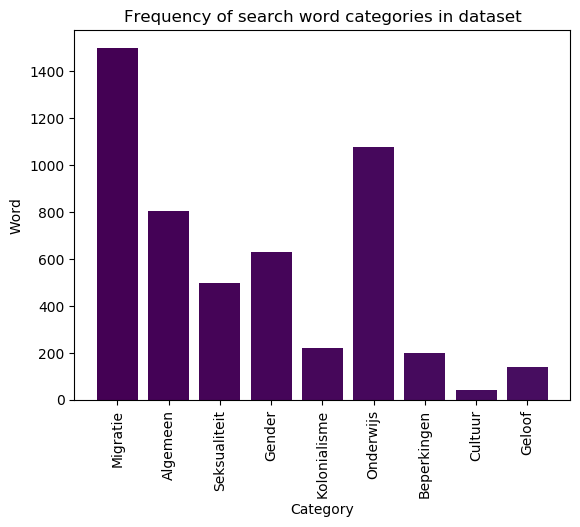

{'Migratie': 1501, 'Algemeen': 803, 'Seksualiteit': 499, 'Gender': 630, 'Kolonialisme': 220, 'Onderwijs': 1078, 'Beperkingen': 200, 'Cultuur': 43, 'Geloof': 140}


In [8]:
# overzicht van de zoekwoorden en de categorieën aanwezig in de dataset
# give overview of search words & their categories in the dataset
dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/" # server 1
#dataset_path = "~/Projecten/programma-discriminatie-en-racisme/datasets/" # server 2

zoekwoorden = pd.read_excel(dataset_path + "Zoekwoorden15.03.24.xlsx", names = ['Categorie', 'Zoekwoord', 'Doel', 'Voorkeur', 'Vermijden', 'Toelichting'])

search_dict = dict(zip(zoekwoorden['Zoekwoord'], zoekwoorden['Categorie']))
#print(search_dict)

# leuk grafiekje van hoe vaak woorden voorkomen
# little graph of how often words occur
word_freq = {}
i = 0

for woord in merged['word']:
    category = search_dict[woord]
    
    if category in word_freq:
        word_freq[category] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[category] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Word')
plt.title('Frequency of search word categories in dataset')
plt.show()

print(word_freq)

In [9]:
print(len(aggregated))

# prepareer dataset voor inladen in model
# prep dataset for loading into model
model_data = aggregated[aggregated.Label < 2.0] # dit zijn de labels 0 en 1 / these are the labels 0 and 1

model_data = model_data.drop(columns = ['id', 'titel', 'zin'])
model_data = model_data.rename(columns={"Label": "label", 'text': 'text'}) # totaalscore/label = doel, text = ingelezen tekst

display(model_data)

4679


,text,word,label
Column1,,,
38,door tegelijkertijd voor werkgevers de verschi...,stromen,0.0
50,de regering is zich zeer bewust van de nederla...,traditie,0.0
53,dienovereenkomstig streeft elke partij ernaar ...,stromen,0.0
110,tweede kamer der staten-generaal 2 vergaderjaa...,hetero,0.0
112,b in de beweegreden wordt «hetero- of homoseks...,hetero,0.0
...,...,...,...
9870,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9874,een functiestoornis is een langdurige of blijv...,fobie,1.0
9910,een prejudiciële procedure is daarmee niet all...,macht,0.0


In [10]:
# hoe vaak komt elk woord voor in de zoekwoordenlijst?
# find frequency of search words 
word_freq_dict = {}

for woord in model_data['word']:
    if woord in word_freq_dict:
        word_freq_dict[woord] += 1
    else:
        word_freq_dict[woord] = 1
        
print(word_freq_dict)

# vinden woorden die < 10 keer voorkomen
# find words that appear < 10 times
new_words_list = []

for key in word_freq_dict:
    value = word_freq_dict[key]
    if value < 10:
        new_words_list.append(key)
        
print(new_words_list)

# verwijderen woorden die weinig voorkomen voor aparte test set
# then, remove instances with key words from this unseen words list for a separate test set
new_words_data = pd.DataFrame()

for new_word in new_words_list:
    new_word_data = model_data[model_data['word'] == new_word]
    new_words_data = pd.concat([new_words_data, new_word_data])

display(new_words_data)

model_data = model_data[~model_data['word'].isin(new_words_data['word'])]
display(model_data)

{'stromen': 521, 'traditie': 38, 'hetero': 53, 'stroom': 473, 'macht': 365, 'geslacht': 255, 'armoede': 214, 'seksueel': 376, 'migranten': 161, 'ouders': 205, 'christen': 38, 'gehandicapt': 146, 'racisme': 31, 'minderheden': 63, 'mankracht': 90, 'meisje': 77, 'afstromen': 19, 'islam': 48, 'zittenblijven': 20, 'homo': 15, 'joods': 16, 'privilege': 20, 'blank': 9, 'hoogopgeleid': 40, 'nieuwkomer': 13, 'opstromen': 9, 'anderstalig': 51, 'slaaf': 12, 'slavernijverleden': 26, 'laagopgeleid': 26, 'kloof': 23, 'slaven': 9, 'transgender': 65, 'jongen': 15, 'arabisch': 31, 'vluchtelingencrisis': 8, 'fobie': 5, 'hoofddoek': 17, 'thuiszitter': 4, 'achterstandsleerling': 2, 'juf': 9, 'verliefd': 4, 'inheems': 6, 'tussenpositie': 3, 'oostblok': 1}
['blank', 'opstromen', 'slaven', 'vluchtelingencrisis', 'fobie', 'thuiszitter', 'achterstandsleerling', 'juf', 'verliefd', 'inheems', 'tussenpositie', 'oostblok']


,text,word,label
Column1,,,
3678,"blank en haelermans, die in het antwoord op vr...",blank,0.0
36171,met recht kunnen we spreken over illusies van ...,blank,0.0
36171,met recht kunnen we spreken over illusies van ...,blank,0.0
3677,niet-dossierstuk over de afgelopen twintig jaa...,blank,0.0
3678,"blank en haelermans, die in het antwoord op vr...",blank,0.0
...,...,...,...
25098,"de wet verbiedt het doden, het vangen en het v...",inheems,0.0
15972,in de structuur van het huidige en het nieuwe ...,tussenpositie,0.0
5006,de nla verzoekt te bezien of het mogelijk is o...,tussenpositie,0.0


,text,word,label
Column1,,,
38,door tegelijkertijd voor werkgevers de verschi...,stromen,0.0
50,de regering is zich zeer bewust van de nederla...,traditie,0.0
53,dienovereenkomstig streeft elke partij ernaar ...,stromen,0.0
110,tweede kamer der staten-generaal 2 vergaderjaa...,hetero,0.0
112,b in de beweegreden wordt «hetero- of homoseks...,hetero,0.0
...,...,...,...
9869,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9870,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9910,een prejudiciële procedure is daarmee niet all...,macht,0.0


In [11]:
# implementeer undersampling, oversampling, normaal sampling
# implementing different sampling strategy
def sampling_strategy(input_frame, strategy = 'normal', max = 0.7, balance = 0.5):
    if strategy == 'oversampling': # F1 = 0.78
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        output_frame = pd.concat([pos, pos, neg]) # double the sample of positive instances
        
    elif strategy == 'undersampling': # F1 = 0.80
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        max_len = int(max*len(neg))
        output_frame = pd.concat([pos, neg[0:max_len]])
        
    elif strategy == 'balanced': # F1 = 0.78
        # len(input_frame) = len(output_frame)
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        neg_len = int(len(input_frame) * balance)
        pos_extra_len = len(input_frame) - neg_len - len(pos)
        output_frame = pd.concat([pos, neg[0:neg_len]])
        
        while pos_extra_len/len(pos) > 1:
            output_frame = pd.concat([output_frame, pos]) # heel extra frame toevoegen / add an entirely new frame
            pos_extra_len -= len(pos)
            
        # anders: overig toevoegen
        # else: add however much is remainng
        output_frame = pd.concat([output_frame, pos[0:pos_extra_len]])
    
    else: #strategy = 'normal' # F1 = 0.78
        output_frame = input_frame[input_frame.label < 2.0] # behoudt alleen labels 0 en 1
    return output_frame

In [12]:
# split dataset: 60% train, 20% val, 20% test
train_val_df, test_df_words = train_test_split(model_data, test_size=0.20, stratify = model_data['label'], random_state=seed)
train_df_words, val_df_words = train_test_split(train_val_df, test_size=0.25, stratify = train_val_df['label'], random_state=seed)

train_df_words = sampling_strategy(train_df_words, strategy = 'undersampling')

train_df = train_df_words.drop(columns = ['word'])
val_df = val_df_words.drop(columns = ['word'])
test_df = test_df_words.drop(columns = ['word'])
new_test_df = new_words_data.drop(columns = ['word'])

print(len(train_df), len(val_df), len(test_df))
print(len(train_df[train_df['label']==1.0]))

2137 713 713
511


In [13]:
# vind de zoekwoorden die niet in de dataset zitten
# find the search words missing from the dataset
zoekwoorden_set = set(test_df_words['word'])

print(len(zoekwoorden_set))

zoekwoorden = set(merged['word'])

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))
print(afwezig)

33
20
{nan, 'tussenpositie', 'man', 'begeleider', 'etnisch', 'thuiszitter', 'fobie', 'ontwikkelingslanden', 'inheems', 'ras', 'oostblok', 'vrouw', 'blank', 'verliefd', 'slaven', 'opstromen', 'west', 'vluchtelingencrisis', 'juf', 'achterstandsleerling'}


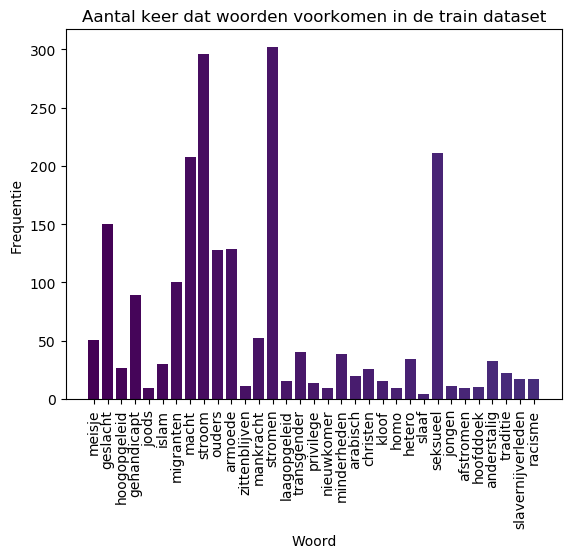

{'meisje': 51, 'geslacht': 150, 'hoogopgeleid': 27, 'gehandicapt': 89, 'joods': 9, 'islam': 30, 'migranten': 100, 'macht': 208, 'stroom': 296, 'ouders': 128, 'armoede': 129, 'zittenblijven': 11, 'mankracht': 52, 'stromen': 302, 'laagopgeleid': 15, 'transgender': 40, 'privilege': 14, 'nieuwkomer': 9, 'minderheden': 39, 'arabisch': 20, 'christen': 26, 'kloof': 15, 'homo': 9, 'hetero': 34, 'slaaf': 4, 'seksueel': 211, 'jongen': 11, 'afstromen': 9, 'hoofddoek': 10, 'anderstalig': 33, 'traditie': 22, 'slavernijverleden': 17, 'racisme': 17}


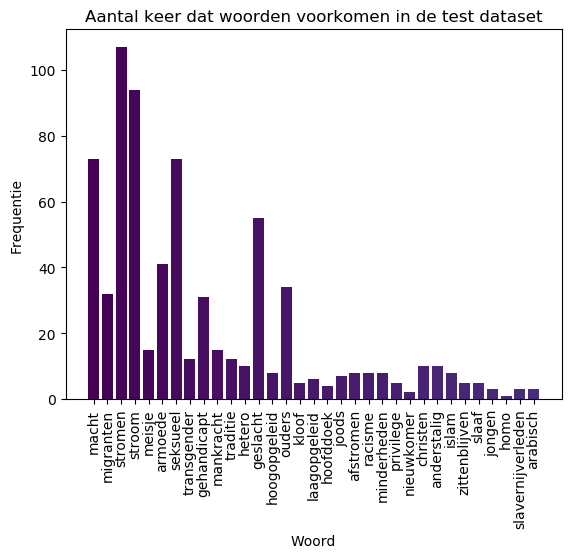

{'macht': 73, 'migranten': 32, 'stromen': 107, 'stroom': 94, 'meisje': 15, 'armoede': 41, 'seksueel': 73, 'transgender': 12, 'gehandicapt': 31, 'mankracht': 15, 'traditie': 12, 'hetero': 10, 'geslacht': 55, 'hoogopgeleid': 8, 'ouders': 34, 'kloof': 5, 'laagopgeleid': 6, 'hoofddoek': 4, 'joods': 7, 'afstromen': 8, 'racisme': 8, 'minderheden': 8, 'privilege': 5, 'nieuwkomer': 2, 'christen': 10, 'anderstalig': 10, 'islam': 8, 'zittenblijven': 5, 'slaaf': 5, 'jongen': 3, 'homo': 1, 'slavernijverleden': 3, 'arabisch': 3}


In [14]:
# hoe vaak zitten woorden in de train set?
# how often are words present in the training set?
word_freq = {}

for woord in train_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1

# plot
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de train dataset')
plt.show()

print(word_freq)

# en in de test set?
# and the test set?
word_freq = {}

for woord in test_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1

# plot
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de test dataset')
plt.show()

print(word_freq)

In [17]:
# hyperparameters zetten
# define hyperparameters
# to change parameters: zie https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
train_args ={"reprocess_input_data": True, # tokenization gebeurt binnen model
             "fp16":False, # vorm van de input van de data
             "silent": False, # zeker weten dat progress bars worden geprint
             "use_multiprocessing": False, # versnelt training
             "use_multiprocessing_for_evaluation": False, # versnelt training
             "overwrite_output_dir": True, # niet ieder model opslaan
             "save_total_limit": 2, # slaat meest recente en beste epoch op
             "save_strategy": 'no', # niet tussentijds opslaan
             "load_best_model_at_end": True, # het beste model inladen
             "num_train_epochs": 4, # hoeveel epochs
             "learning_rate": 0.00002, # learning rate
             "weight_decay": 0.1,
             "optimizer": 'AdamW',
             #"loss_type": "custom",
             #"hidden_dropout_prob": 0.3,
             "evaluate_during_training": True, # om validation data in te laten
            "evaluation_strategy":"epoch", # slaat een tussentijds model op om te evalueren
            #"eval_steps": 2000, # hoe vaak het model wordt opgeslagen
            "train_batch_size": 8, # batch size trainingsdata
            "eval_batch_size": 8} # batch size validation data

model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.fp16 = False
model_args.silent = False
model_args.use_multiprocessing = False
model_args.use_multiprocessing_for_evaluation = False
model_args.overwrite_output_dir = True
model_args.save_total_limit = 2
model_args.save_strategy = "no"
model_args.load_best_model_at_end = True
model_args.num_train_epochs = 4
model_args.learning_rate = 0.00002
model_args.optimizer = "AdamW"
model_args.relative_step = True
model_args.warmup_init = True
model_args.evaluation_during_training = True
model_args.evaluation_strategy = "epoch"
model_args.hidden_dropout_prob = 0.3
model_args.train_batch_size = 8
model_args.eval_batch_size = 8
model_args.no_cache = False
model_args.weight_decay = 0.1
#model_args.loss_type = 'custom'  # Custom loss type (optional, for clarity)

# Create a ClassificationModel (code uit bron; zie bovenaan notebook)
model = ClassificationModel(
    "bert", "GroNLP/bert_dutch_base_offensive_language",
    #"roberta", "DTAI-KULeuven/robbert-2023-dutch-base",
    #"roberta", "pdelobelle/robbert-v2-dutch-base", # RobBERT
    #"bert", "GroNLP/bert-base-dutch-cased", # Nederlands!!
    #"bert", "bert-base-uncased", # English!!
    num_labels=2, # hoeveel mogelijke targets er zijn
    args=train_args,
    use_cuda=False # omdat dit op de cpu draait
)

In [18]:
# trainen!
train_results = model.train_model(train_df = train_df, eval_df = val_df)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/268 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/268 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/268 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/268 [00:00<?, ?it/s]

In [19]:
# testen
from sklearn.metrics import f1_score, accuracy_score

# om f1 te kunnen genereren
# to generate f1-score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)


Running Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]

In [20]:
# resultaten: mcc = , tp = true positives, tn = true negatives, fp = false negatives, fn = false negatives
print(result)

# 0.7806059741456883, lr = 0.00002, batch = 8, oversampling
# 0.7618282264590501, lr = 0.002, batch = 8, oversampling
# 0.80, lr = default, batch = 8, undersampling
# 0.7892210553443721, lr = 0.00002, batch = 24, oversampling
# 0.7727849196570864, lr = 0.00002, batch = 24, balanced sampling
# 0.7643486483807626, lr = 0.00002, batch = 24, undersampling
# 0.7721387757070184, lr = 0.0002, batch = 24, undersampling
# 0.7656888451873702, lr = default, batch = 8, undersampling
# 0.7819736575481258, batch = 24, epochs = 8, oversampling (doubled)
# 0.7618978588149389, hidden dropout of 0.5, balanced sampling
# 0.7750330201139665, dropout 0.8, balanced sampling
# 0.7470579808026853, category = oversampling
# 0.7551529031388926, dropout 0.5, batch size = 4
# 0.7599348682562457, weight decay = 0.01
# 0.68260712156061, lr = 0.000002, weight decay = 0.1, batch = 8
# 0.6687961596234598, lr = 0.000002, weight decay = 0
# 0.7672738336177362, lr = 0.00002, weight decay = 0.1, batch = 24
# 0.7565585210545067, epochs = 8, weight decay = 0.2
# 0.7620034919249236, epochs = 8, batch = 8, weight decay = 0.2
# 0.758152920054916, epochs = 16
# 0.7524879530693485, epochs = 7, weight decay = 0.15
# , batch size = 4

### NEW MODEL: RobBERT
# 0.7811859752877811, batch size = 4, weight decay = 0.1, lr = 0.00002
# 0.7692155842770064, weight decay = 0.15
# 0.783823966696402, lr = 0.00005, weight decay = 0
# 0.7778996836056733, lr = .00004, weight decay = 0.1, batch size = 8
#, lr = 0.00002, wd = 0.1, batch = 8, hidden dropout = 0.3
# 0.793115677255728, oversampling
# # 0.8076198762141803, undersampling
# 0.7858508082131935, weight decay = 0.0
# 0.8068071223180712, dropout = 0.3

### HateBERT
# 0.7922292374939293, 0.4569444444444445

{'mcc': 0.5894101748227991, 'tp': 107, 'tn': 504, 'fp': 38, 'fn': 64, 'auroc': 0.8809963099630996, 'auprc': 0.7658110536309428, 'f1': 0.792661648990763, 'acc': 0.8569424964936886, 'eval_loss': 0.8127008081742032}


In [21]:
# testen op ongeziene woorden
# test on unseen words
new_test_df = new_words_data.drop(columns = ['word'])

new_result, new_model_outputs, new_wrong_predictions = model.eval_model(new_test_df, f1=f1_multiclass, acc=accuracy_score)

print(new_result)

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

{'mcc': 0.27015773716545627, 'tp': 12, 'tn': 26, 'fp': 2, 'fn': 29, 'auroc': 0.6363240418118468, 'auprc': 0.7661881396461132, 'f1': 0.5314348302300109, 'acc': 0.5507246376811594, 'eval_loss': 2.719450243645244}


(1072, defaultdict(<class 'list'>, {'global_step': [268, 536, 804, 1072], 'train_loss': [0.042423076927661896, 0.339193731546402, 0.0004233417857903987, 0.00036161558819003403], 'mcc': [0.5421675521547287, 0.5845795300058264, 0.5781024434757207, 0.5941907112403743], 'tp': [67, 117, 113, 105], 'tn': [537, 488, 492, 508], 'fp': [5, 54, 50, 34], 'fn': [104, 54, 58, 66], 'auroc': [0.865988001985283, 0.8859379383267516, 0.876658898167929, 0.871717269804277], 'auprc': [0.7504731405589997, 0.761834794681077, 0.7596631227552706, 0.7500140064106929], 'eval_loss': [0.3797716452429692, 0.4890927674455775, 0.6524519137300862, 0.8174286496110855]}))


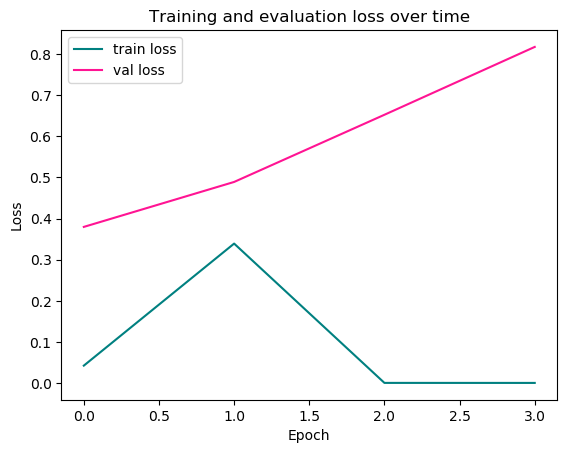

In [22]:
# maak een plotje van de loss
# plot loss
print(train_results)

train_losses = train_results[1]['train_loss']
eval_losses = train_results[1]['eval_loss']

plt.plot(train_losses, c = 'teal', label = 'train loss')
plt.plot(eval_losses, c = 'deeppink', label = 'val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and evaluation loss over time')
plt.show()

In [23]:
# bekijken outputs
# look at outputs
print(model_outputs)

probabilities = expit(model_outputs) # dit is de sigmoid van de voorspelling
print(probabilities)

[[ 3.86324811 -3.65187311]
 [-3.11079216  3.4046073 ]
 [ 4.13039637 -4.12169743]
 ...
 [ 1.41509175 -1.42603445]
 [ 4.31820059 -4.33656311]
 [ 3.97836161 -4.01140594]]
[[0.97943224 0.0252865 ]
 [0.04266428 0.96784821]
 [0.98417786 0.01595817]
 ...
 [0.8045678  0.19371731]
 [0.98685135 0.0129125 ]
 [0.98162758 0.01778585]]


In [24]:
# voorspellen en opslaan outputs
# predict values
predictions, raw_outputs = model.predict(list(test_df['text']))

new_predictions, new_raw_outputs = model.predict(list(new_test_df['text']))


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [25]:
# bekijken voorspellingen
# view predictions
print(predictions)
print(list(test_df['label']))

print(new_predictions)
print(list(new_test_df['label']))

[0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1
 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1
 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 

0.6257309941520468 0.9298892988929889 0.07011070110701106 0.3742690058479532
107 504 38 64


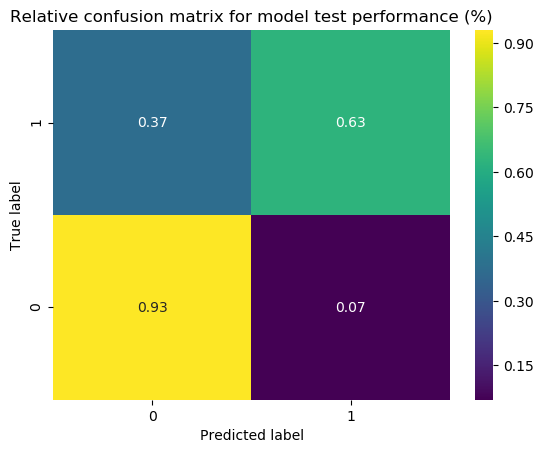

In [26]:
# confusion matrix
tp = result['tp']
tn = result['tn']
fp = result['fp']
fn = result['fn']
total = tp+tn+fp+fn

tp_rel = tp/(tp+fn)
tn_rel = tn/(tn+fp)
fp_rel = fp/(tn+fp)
fn_rel = fn/(tp+fn)

print(tp_rel, tn_rel, fp_rel, fn_rel)
print(tp, tn, fp, fn)

cm = np.array([[tn_rel, fp_rel], [fn_rel, tp_rel]])
ax = sns.heatmap(cm, annot = True, cmap = "viridis")
ax.set_ylim([0,2])
plt.title("Relative confusion matrix for model test performance (%)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

[[0.02056776 0.9747135 ]
 [0.95733572 0.03215179]
 [0.01582214 0.98404183]
 ...
 [0.1954322  0.80628269]
 [0.01314865 0.9870875 ]
 [0.01837242 0.98221415]]


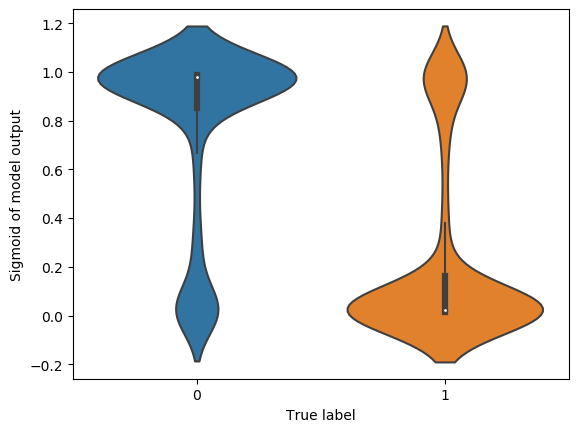

In [27]:
# onzekerheid van model met violinplot
# uncertainty of model (violinplot)
print(1-probabilities)

sns.violinplot(data = probabilities)
plt.ylabel("Sigmoid of model output")
plt.xlabel("True label")
plt.show()

{'macht': 0.9315068493150684, 'migranten': 0.8125, 'stromen': 0.9065420560747663, 'stroom': 0.9893617021276596, 'meisje': 0.6666666666666666, 'armoede': 0.8048780487804879, 'seksueel': 0.8904109589041096, 'transgender': 0.6666666666666666, 'gehandicapt': 0.9354838709677419, 'mankracht': 0.9333333333333333, 'traditie': 0.75, 'hetero': 0.9, 'geslacht': 0.7454545454545455, 'hoogopgeleid': 1.0, 'ouders': 0.7647058823529411, 'kloof': 0.6, 'laagopgeleid': 1.0, 'hoofddoek': 0.5, 'joods': 0.7142857142857143, 'afstromen': 0.625, 'racisme': 1.0, 'minderheden': 0.25, 'privilege': 1.0, 'nieuwkomer': 0.0, 'christen': 0.9, 'anderstalig': 0.9, 'islam': 0.75, 'zittenblijven': 1.0, 'slaaf': 0.6, 'jongen': 0.6666666666666666, 'homo': 1.0, 'slavernijverleden': 0.3333333333333333, 'arabisch': 1.0}


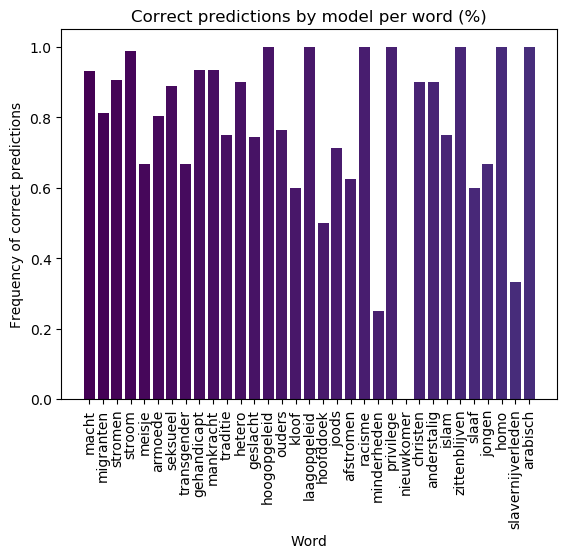

In [28]:
# kijken naar betrouwbaarheid per zoekwoord
# look at reliability per search word
test_df_words['predicted'] = predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(test_df_words)):
    woord = test_df_words['word'].iloc[i]
    label = test_df_words['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(dict_label_relative.keys(), dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per word (%)')
plt.show()

{'blank': 0.8888888888888888, 'opstromen': 0.2222222222222222, 'slaven': 0.5555555555555556, 'vluchtelingencrisis': 0.125, 'fobie': 0.8, 'thuiszitter': 0.5, 'achterstandsleerling': 1.0, 'juf': 0.3333333333333333, 'verliefd': 0.5, 'inheems': 1.0, 'tussenpositie': 1.0, 'oostblok': 0.0}
{'blank': 0.0, 'opstromen': 0.8888888888888888, 'slaven': 1.0, 'vluchtelingencrisis': 0.875, 'fobie': 0.2, 'thuiszitter': 1.0, 'achterstandsleerling': 1.0, 'juf': 0.6666666666666666, 'verliefd': 0.75, 'inheems': 0.0, 'tussenpositie': 0.0, 'oostblok': 1.0}


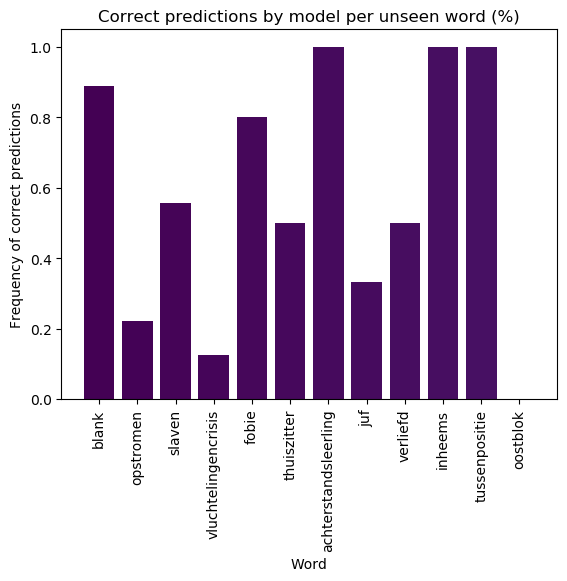

In [29]:
# kijken naar betrouwbaarheid voor nieuwe woorden
# look at accuracy for new predictions
new_test_df['predicted'] = new_predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(new_words_data)):
    woord = new_words_data['word'].iloc[i]
    label = new_words_data['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)
print(dict_label_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(r+width, dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per unseen word (%)')

plt.show()